# 📝 Pattern Recognition & Biometrics. TP Régression

Par Omar Galarraga et Sonia Garcia

L'objectif de ce travail pratique est de réaliser des tâches de régression : 

* Linéaire simple
* Multilinéaire (avec et sans régularisation)
* Non linéaire avec réseaux de neurones

Nous voudrons prédire le prix médian des maisons californiennes par quartier en fonction de plusieurs variables quantitatives. 

Commençons par charger les données et regarder la description de la base de données :


In [1]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import numpy as np

california_housing = fetch_california_housing(as_frame=True)
#print(california_housing.frame.head())
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

* 0.1) Montrez l'histogramme des variables (Piste : *california_housing.frame* contient un DataFrame de Pandas) 

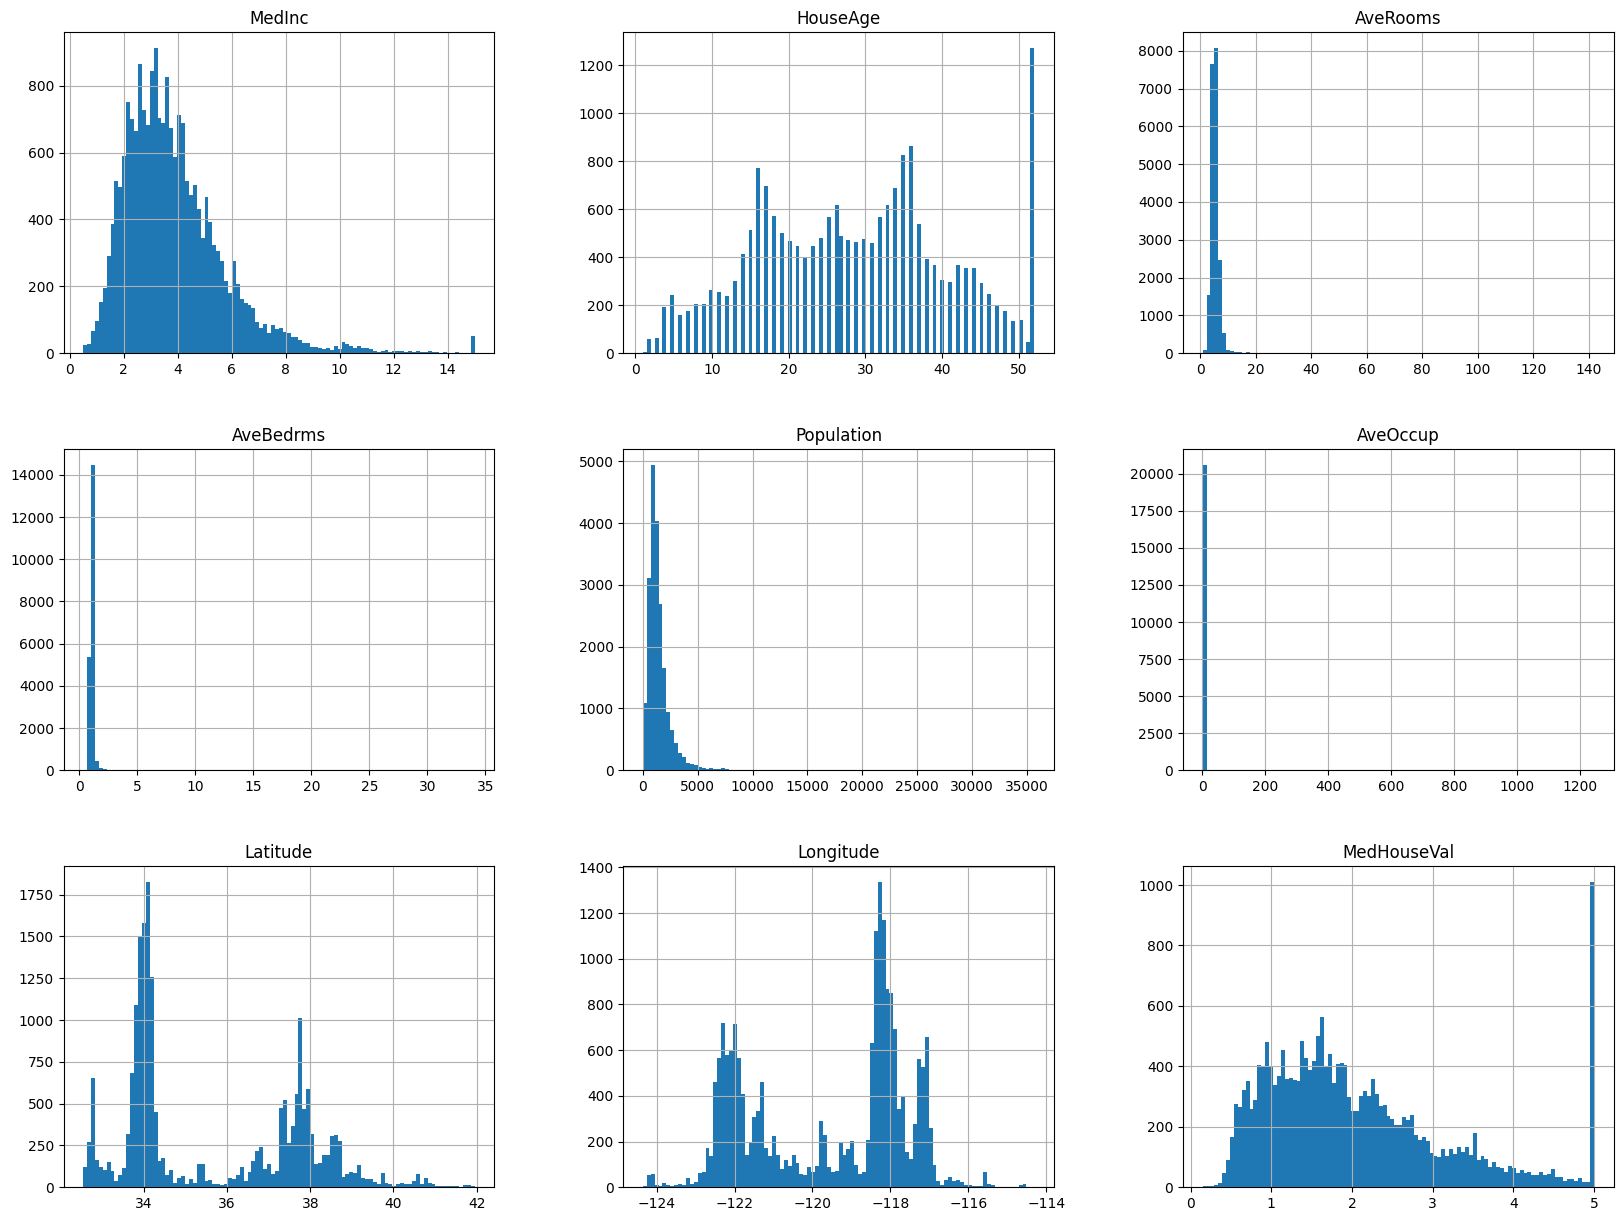

In [2]:

def plot_hist():
    california_housing.frame.hist(bins=100, figsize=(20,15))
    plt.show()
plot_hist()

## Partie I. Régression linéaire simple

Calculez la matrice de corrélations.

* I.1) Si vous deviez choisir une seule variable pour réaliser une régression linéaire simple, laquelle choisiriez-vous ? Pourquoi ? 

In [3]:
corr_matrix = california_housing.frame.corr()

best_one = corr_matrix["MedHouseVal"].sort_values(ascending=False)
print(best_one)
# Choisir MedInc car forte corrélation avec la target MedInc

MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64


Nous voudrons créer un modèle $ \hat{y} = ax + b $, où $ \hat{y} $ est la prédiction du prix médian des maisons par quartier et $x$ est la caractéristique choisie en I.1.

* I.2) Quelles sont les valeurs optimales de $ a $ et $ b $ ? 

In [4]:
def moindre_carre_a_b(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    x_var = x.var()
    y_var = y.var()
    xy = x * y
    xy_mean = xy.mean()
    a = (xy_mean - x_mean * y_mean) / x_var
    b = y_mean - a * x_mean
    return a, b
x = california_housing.frame["MedInc"]
y = california_housing.frame["MedHouseVal"]
a,b = moindre_carre_a_b(x, y)
print("Notre modèle est y = {} * x + {}".format(a,b))

Notre modèle est y = 0.4179182430610166 * x + 0.45093414408704025


* I.3) Quelle est la valeur de $R^2$ ? Est-ce un bon ajustement ? Commentez
* I.4) Tracez la courbe de régression sur le nuage de points entre la sortie désirée et l'entrée

In [5]:
def calculate_r2(x, y, a, b):
    y_mean = y.mean()
    y_pred = a * x + b
    ss_res = ((y - y_pred) ** 2).sum()
    ss_tot = ((y - y_mean) ** 2).sum()
    return 1 - ss_res / ss_tot

r2 = calculate_r2(x, y, a, b)
print(r2)

# On obtient un R2 de 0.47, ce qui est assez faible. On peut donc dire que notre modèle n'est pas très bon.

0.473447490695845


* I.5) Quelle est l'erreur RMS de prédiction ? (en moyenne sur toutes les observations)

In [6]:
calculate_RMS = lambda x, y, a, b: ((y - a * x - b) ** 2).mean() ** 0.5
RMS = calculate_RMS(x, y, a, b)
print(RMS)

0.8373357461453419


## Partie II. Régression multilinéaire

Maintenant réalisez une régression linéaire en utilisant toutes les caractéristiques disponibles. 

* II.1) Quelle est l'erreur de prédiction ?
* II.2) Quelle est la valeur de $R^2$ ? L'ajustement est-il meilleur qu'avec une seule variable d'entrée ?
* II.3) Quels sont les coefficients associés aux variables d'entrée, ainsi que le terme indépendant ?

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = california_housing.frame["MedHouseVal"]
X = california_housing.frame.drop("MedHouseVal", axis=1)

def multilinear_regression():
    X = california_housing.frame.drop("MedHouseVal", axis=1)
    y = california_housing.frame["MedHouseVal"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    lin_mse = mean_squared_error(y_test, y_pred)
    lin_rmse = lin_mse ** 0.5
    print("Linear regression RMSE: ", lin_rmse)
    print("Linear regression R2: ", lin_reg.score(X_test, y_test))


def multilinear_regression_with_cost(alpha, X = X, y = y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    n = X_train.shape[1]
    I = np.eye(n)
    I[0, 0] = 0
    
    w = np.linalg.pinv(X_train.T @ X_train + alpha * I) @ X_train.T @ y_train
    y_pred = X_test @ w
    lin_mse = mean_squared_error(y_test, y_pred)
    lin_rmse = np.sqrt(lin_mse)
    print("Linear regression RMSE: ", lin_rmse)


#On a un R2 plus proche de 1 et un RMSE plus proche de 0 avec la régression linéaire multiple. On peut donc dire que ce modèle est meilleur que le précédent. Cependant
#on peut encore l'améliorer en utilisant un modèle plus complexe.
    

multilinear_regression_with_cost(0.1)
multilinear_regression_with_cost(0.5)

Linear regression RMSE:  0.7455754517462169
Linear regression RMSE:  0.7455517729756443


Maintenant nous allons introduire un terme de régularisation, donc la nouvelle fonction de coût est : $$ J' = J + \alpha\sum_{i}{w_i^2} $$
* II.4) Quelle est la valeur optimale du paramètre $\alpha$ ? (Trouvez-la empiriquement) 
* II.5) Quelle est l'erreur RMS avec $\alpha$ optimal ?

Ajoutez des variables polynomiales d'ordre $o=2$ aux variables déjà disponibles. Comparez la régression avec et sans régularisation (RMSE, $R^2$)
* II.6) Laquelle donne des meilleurs résultats ? Pourquoi ?  

In [8]:
#Ecrivez votre code ici

## Partie III. Régression non linéaire avec réseaux de neurones

Construisez et entraînez un réseau de neurones type Perceptron Multicouche (PMC) à $N_{layer} = 3$ couches et avec $m=5$ neurones dans la couche cachée.

N'oubliez pas de normaliser les données en prétraitement. 

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

N_layer = 3
m = 5

X = california_housing.frame.drop("MedHouseVal", axis=1)
y = california_housing.frame["MedHouseVal"].values.reshape(-1, 1)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

neural_network = MLPRegressor(hidden_layer_sizes=(m,) * N_layer)
neural_network.fit(X_train, np.ravel(y_train))
y_pred = neural_network.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(mse, rmse)

# On obtient un score un peu meilleur que la régression linéaire multiple.

c:\Users\Skander\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2544090659975981 0.504389795691386


c:\Users\Skander\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



* III.1) Quelle sont les prix prédits pour les dix premières observations ?
* III.2) Quelle est l'erreur RMS d'apprentissage ?

In [10]:
first_10_rows = X.head(10)
first_10_predictions = scaler_y.inverse_transform(list(map(lambda x : [x],neural_network.predict(scaler_x.transform(first_10_rows)))))
VAL_PREDICTIONS = [(y[k], first_10_predictions[k]) for k in range(10)]
s = '\n'.join(['Real Value : {:}, Predicted Value : {:}'.format(str(y[k][0]), str(first_10_predictions[k][0])) for k in range(10)])
print(s) 

# Les prédictions ont l'air correctes


Real Value : 4.526, Predicted Value : 4.285102090561527
Real Value : 3.585, Predicted Value : 4.4967402824890055
Real Value : 3.521, Predicted Value : 4.1229895149678395
Real Value : 3.413, Predicted Value : 3.3870566513418887
Real Value : 3.422, Predicted Value : 2.6862582925576977
Real Value : 2.697, Predicted Value : 2.9740184496748188
Real Value : 2.992, Predicted Value : 2.7481878829637485
Real Value : 2.414, Predicted Value : 2.9440085820578794
Real Value : 2.267, Predicted Value : 1.8563961368768234
Real Value : 2.611, Predicted Value : 2.8138184811973943


Réalisez une validation croisée type *K-Fold* avec $K=10$ (n'oubliez pas de mélanger les données préalablement)

* III.3) Quelle sont les erreurs RMS d'apprentissage et de test ? (Moyenne et écart-type)

In [11]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

K = 10
N_layer = 3
m = 5

def realize_K_fold_cross(K= K, N_layer = N_layer, m = m):
    data = california_housing.frame.sample(frac=1).reset_index(drop=True)
    X = data.drop("MedHouseVal", axis=1)
    y = data["MedHouseVal"].values.reshape(-1, 1)

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    kf = KFold(n_splits=K, shuffle=True)

    mse_train_list = []
    mse_test_list = []

    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]

        neural_network = MLPRegressor(hidden_layer_sizes=(m,) * N_layer)
        neural_network.fit(X_train, y_train)
        y_train_pred = neural_network.predict(X_train)
        y_test_pred = neural_network.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)

    mse_train_mean = np.mean(mse_train_list)
    mse_train_std = np.std(mse_train_list)
    mse_test_mean = np.mean(mse_test_list)
    mse_test_std = np.std(mse_test_list)

    print("Mean RMSE (train):", np.sqrt(mse_train_mean))
    print("Standard deviation RMSE (train):", np.sqrt(mse_train_std))
    print("Mean RMSE (test):", np.sqrt(mse_test_mean))
    print("Standard deviation RMSE (test):", np.sqrt(mse_test_std))
    return np.sqrt(mse_test_list)



In [13]:
realize_K_fold_cross()

c:\Users\Skander\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Skander\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Skander\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\Skander\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConvers

Mean RMSE (train): 0.4957609483413848
Standard deviation RMSE (train): 0.09770063230053223
Mean RMSE (test): 0.4985110705746772
Standard deviation RMSE (test): 0.12102948239349216


array([0.50779516, 0.5229434 , 0.48851157, 0.5090843 , 0.5107085 ,
       0.48302304, 0.48449243, 0.47275523, 0.50031273, 0.50330817])

Optimisez le nombre de neurones $m$ dans la couche cachée (Piste : réalisez la validation croisée pour différentes valeurs de $m$)

* III.4) Quelle est la valeur optimale de $m$ ? Pourquoi ? 

In [17]:
rmse_list = []
for m in range(1, 10):
    rmse_folds_m = realize_K_fold_cross(m=m)
    rmse_list.append(rmse_folds_m.mean())
m_opt = np.argmin(rmse_folds_m) + 1
print("Optimal number of neurons in the hidden layer: {}".format(m_opt))

#On remarque que 4 est suffisant, 5 est un peu mieux en terme de mean bien que parmi les folds on ait une plus grande déviation, 6 est bon mais plus long en calcul

c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Pyth

Mean RMSE (train): 0.8166630677717788
Standard deviation RMSE (train): 0.5773873323096133
Mean RMSE (test): 0.8190184694433618
Standard deviation RMSE (test): 0.5815957383702017


c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Pyth

Mean RMSE (train): 0.5995207049053769
Standard deviation RMSE (train): 0.46409840965602384
Mean RMSE (test): 0.6015558359106633
Standard deviation RMSE (test): 0.4452794361458337


c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Pyth

Mean RMSE (train): 0.5266667491761362
Standard deviation RMSE (train): 0.11474539406449
Mean RMSE (test): 0.5320883257631683
Standard deviation RMSE (test): 0.13283990106648394


c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multila

Mean RMSE (train): 0.5022124924605802
Standard deviation RMSE (train): 0.08567036299685199
Mean RMSE (test): 0.5066659243138758
Standard deviation RMSE (test): 0.1274368925526795


c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Pyth

Mean RMSE (train): 0.497024148400541
Standard deviation RMSE (train): 0.1032729541468592
Mean RMSE (test): 0.4997242253719053
Standard deviation RMSE (test): 0.13888808966447405


c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\skand\AppData\Local\Programs\Python\Pyth

Mean RMSE (train): 0.4827052096523726
Standard deviation RMSE (train): 0.08976527837962374
Mean RMSE (test): 0.48761928849943903
Standard deviation RMSE (test): 0.11459200652564164
Optimal number of neurons in the hidden layer: {m_opt}


Pour une validation-croisée type K-Fold avec $K=10$ (mélangez l'ordre des observations), remplissez le tableau de RMSE de test ci-dessous selon les différents types de régression.

| Type de régression | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Fold 6 | Fold 7 | Fold 8 | Fold 9 | Fold 10 |
|--------------------|---------|--------|--------|-------|--------|-------|---------|--------|--------|---------|
| Linéaire simple    |  |  |  |  |  |  |  |  |  |  |
| Multilinéaire sans régul.    |  |  |  |  |  |  |  |  |  |  |
| Multilinéaire avec régul.    |  |  |  |  |  |  |  |  |  |  |
| Polynomiale sans régul.    |  |  |  |  |  |  |  |  |  |  |
| Polynomiale avec régul.    |  |  |  |  |  |  |  |  |  |  |
| Non linéaire avec NN    |  |  |  |  |  |  |  |  |  |  |

* III.5) Quelle est la méthode de régression la plus adaptée pour ce problème ? Justifiez
